In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from datetime import datetime
import time
import math
import scipy
import xgboost as xgb
import time
import seaborn as sns
from scipy import stats
import graphviz

os.chdir('C:\\Users\\Julio\\Documents\\Data_science\\Continental\\Data')

In [2]:
df_train=pd.read_feather("df_train")
df_test=pd.read_feather("df_test")

C:\Users\Julio\Anaconda3\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [66]:
data_train=df_train.groupby(by=["codCliente", "codEstab"], as_index=False).nth(0)
data_train.drop(columns="ratingMonto", inplace=True)
data_train.reset_index(drop=True, inplace=True)
var_target=df_train.groupby(by=["codCliente", "codEstab"], as_index=False).agg({"ratingMonto":"mean"})
data_train=data_train.merge(var_target, on=["codCliente", "codEstab"])

C:\Users\Julio\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [69]:
data_train_1=data_train[(data_train.cant_visitas_estab>5)&(data_train.ctdVisitas_cliente>5)&(data_train.ratingMonto_total<1)&
                        (data_train.ratingMonto<0.5)]

In [71]:
len(data_train_1)

678992

In [72]:
variables_independientes=['codCliente', 'codGiro', 'codEstab', 'flagLimaProvEstab',
       'ubigeoEstab','ctdVisitas_cliente_estab', 
       'ratingMonto_cliente_min', 'ratingMonto_cliente_max',
       'ratingMonto_cliente_mean', 'ratingMonto_cliente_median',
       'cantEstab_cliente', 'ctdVisitas_cliente', 'ctdTrx_cliente',
       'cant_ubigeoEstab_cliente', 'moda_ubigeoEstab_cliente',
       'cant_codGiro_cliente', 'moda_codGiro_cliente','lag_ultima_visita_cliente',
        'flagGenero', 'flagLimaProvCliente', 'ubigeoCliente', 'flagBxi',
        'total_ratingMonto_estab', 'mean_ratingMonto_estab',
       'median_ratingMonto_estab', 'ctdTrx_estab', 'cant_visitas_estab',
       'cant_codCliente_estab', 'moda_ubigeoCliente_estab',
       'cant_ubigeoCliente_estab', 'lag_ultima_visita_estab', 'total_ratingMonto_giro', 'mean_ratingMonto_giro',
       'median_ratingMonto_giro', 'ctdTrx_giro', 'cant_visitas_giro',
       'cant_codCliente_giro', 'moda_ubigeoCliente_giro',
       'cant_ubigeoCliente_giro', 'lag_ultima_visita_giro',  'rangoIngreso_Rango1', 'rangoIngreso_Rango2',
       'rangoIngreso_Rango3', 'rangoIngreso_Rango4', 'rangoIngreso_Rango5',
       'rangoIngreso_Rango6', 'rangoEdad_Rango1', 'rangoEdad_Rango2',
       'rangoEdad_Rango3', 'rangoEdad_Rango4', 'rangoEdad_Rango5',
       'rangoEdad_Rango6', 'saldoTcEntidad1_Rango1', 'saldoTcEntidad1_Rango2',
       'saldoTcEntidad1_Rango3', 'saldoTcEntidad1_Rango4',
       'saldoTcEntidad1_Rango5', 'saldoTcEntidad1_Rango6']

data_train_indep=data_train_1[variables_independientes]
y_train=data_train_1["ratingMonto"]
data_test_indep=df_test[variables_independientes]
y_test=df_test["ratingMonto"]

### Entrenamos el modelo
1er 
Train  0.017801448780840702
Test   0.028650447899314764

In [73]:
tune_gamma=0.05
xgb_model = xgb.XGBRegressor(n_jobs=-1,n_estimators=100, subsample=0.5,max_depth=20, 
                             colsample_bytree=0.5, silent=True, eta=0.1, gamma=tune_gamma)
start=time.time()
xgb_model.fit(data_train_indep, y_train)
duracion=(time.time()-start)/60
print("Entrenamiento completado. Tomo", duracion, "minutos")

Entrenamiento completado. Tomo 10.0491836587588 minutos


In [74]:
def error(data, y, modelo):
    y_p = modelo.predict(data)
    y_p_1=np.where(y_p<0, 0, y_p)
    print('RSME sin truncar',math.sqrt(mean_squared_error(y, y_p)))
    print('RSME truncando',math.sqrt(mean_squared_error(y, y_p_1)))

In [75]:
error(data_train_indep, y_train, xgb_model)

RSME sin truncar 0.01733050812781025
RSME truncando 0.017329967831092908


In [76]:
error(data_test_indep, y_test, xgb_model)

RSME sin truncar 0.02810873802428677
RSME truncando 0.028108188495035942


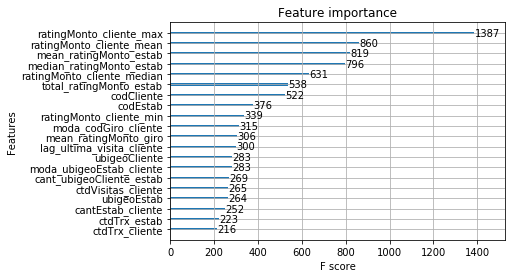

In [77]:
xgb.plot_importance(xgb_model, max_num_features=20)

### Data para someter
#### 1er intento 

In [59]:
##### 3er intento 0.03956 
##### cortando outliers en el percentil 0.99

data_test_kaggle=data_test_kaggle[variables_independientes]

In [60]:
y_p_test_key_rec = xgb_model.predict(data_test_kaggle)

In [61]:
y_p_test_key_rec_1=np.where(y_p_test_key_rec<0, 0, y_p_test_key_rec)

In [62]:
data_test_kaggle["ratingMonto"]=y_p_test_key_rec_1
data_test_kaggle["codClienteCodEstab"]=data_test_kaggle.codCliente.map(str)+data_test_kaggle.codEstab.map(str)

In [63]:
prediccion_final=data_test_kaggle[["codClienteCodEstab", "ratingMonto"]]

In [64]:
prediccion_final.head().T

,0,1,2,3,4
codClienteCodEstab,118268644,118231068,11824288,118215803,118241883
ratingMonto,0.0243658,0.0155172,0.0148215,0.0122721,0.00944814


In [65]:
len(prediccion_final)

467203

In [66]:
prediccion_final.to_csv("submission", sep=',', index=False)

In [404]:
!rar a submission

"rar" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
